## Building ML models based on the inventory map

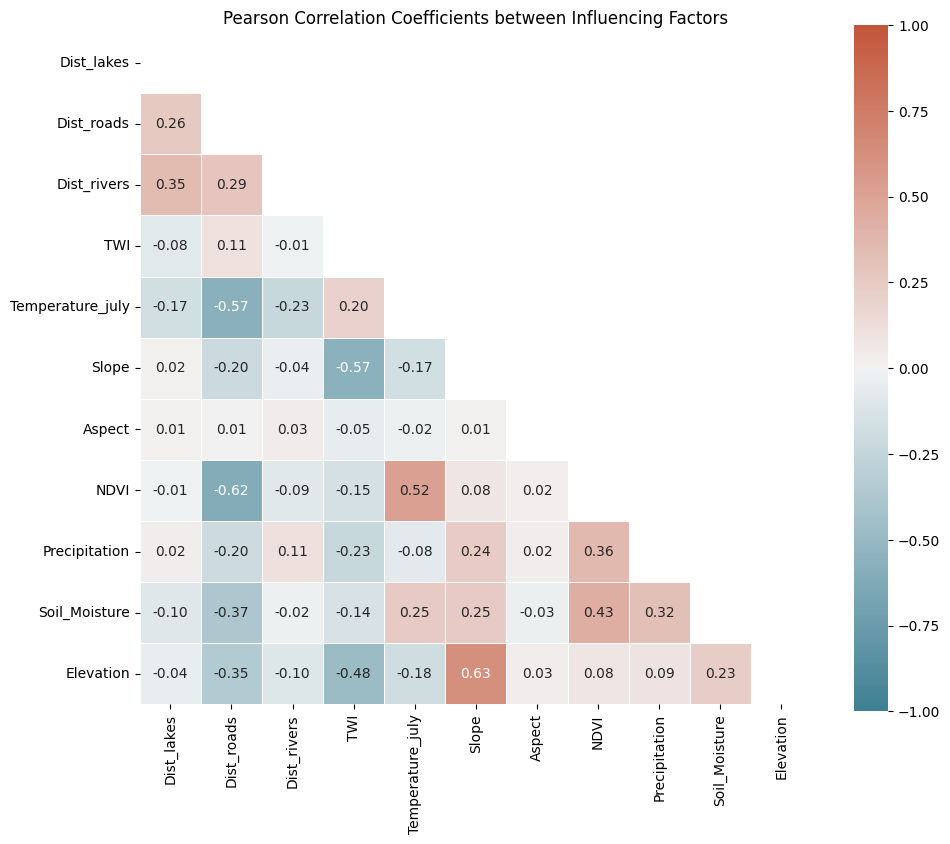

In [20]:
# Install required packages
!pip install shap boruta

# Import libraries
import pandas as pd
import numpy as np
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from boruta import BorutaPy
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, Bidirectional, LSTM, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

# Load the data
df = pd.read_csv('WF2_numeric.csv', names=[
    'Index', 'Wildfire_status', 'X', 'Y', 'Dist_lakes', 'Dist_roads', 'Dist_rivers', 'TWI',
    'Temperature_july', 'Slope', 'Aspect', 'LULC', 'NDVI', 'Precipitation', 'Soil_Moisture', 'Elevation'], header=0)

# Data Cleaning and Preprocessing
df = df[df['LULC'] != 0]
replace_values_LULC = {
    1: 'Urban_areas', 2: 'Crop_land', 3: 'Grass_land', 4: 'Tree_covered', 5: 'Shrub_covered',
    6: 'Herbaceous', 7: 'Sparse_vegetation', 8: 'Bare_soil', 9: 'Snow', 10: 'Water_bodies', 11: 'Sparse_vegetation'}
df['LULC'] = df['LULC'].replace(replace_values_LULC)
df = df.astype({'LULC': 'category'})

# Drop unnecessary columns
df = df.drop(columns=['Index', 'X', 'Y'], axis=1)

# Plot Pearson Correlation Coefficient heatmap
numerical_df = df.drop(columns=['LULC', 'Wildfire_status'])
correlation_matrix = numerical_df.corr(method='pearson')
plt.figure(figsize=(10, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, square=True, annot=True, fmt=".2f", linewidths=0.5, cbar_kws={"shrink": 0.75})
plt.title('Pearson Correlation Coefficients between Influencing Factors')
plt.tight_layout()
plt.show()

# Split the data into training, validation, and test sets
X = df.drop(columns=['Wildfire_status'])
y = df['Wildfire_status']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Data Preprocessing: Encode categorical and scale numerical features
categorical_columns = ['LULC']
numerical_columns = ['Dist_lakes', 'Dist_roads', 'Dist_rivers', 'TWI', 'Temperature_july', 'Slope', 'Aspect', 'NDVI', 'Precipitation', 'Soil_Moisture', 'Elevation']

encoder = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()

X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train[categorical_columns]), columns=encoder.get_feature_names_out(categorical_columns))
X_val_encoded = pd.DataFrame(encoder.transform(X_val[categorical_columns]), columns=encoder.get_feature_names_out(categorical_columns))
X_test_encoded = pd.DataFrame(encoder.transform(X_test[categorical_columns]), columns=encoder.get_feature_names_out(categorical_columns))

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[numerical_columns]), columns=numerical_columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val[numerical_columns]), columns=numerical_columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[numerical_columns]), columns=numerical_columns)

# Concatenate the encoded and scaled features
X_train_final = pd.concat([X_train_scaled.reset_index(drop=True), X_train_encoded.reset_index(drop=True)], axis=1)
X_val_final = pd.concat([X_val_scaled.reset_index(drop=True), X_val_encoded.reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_scaled.reset_index(drop=True), X_test_encoded.reset_index(drop=True)], axis=1)

# Feature Importance using Boruta and CART
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5, random_state=42)
rf.fit(X_train_final, y_train)

# Boruta Feature Selection
boruta = BorutaPy(estimator=rf, n_estimators='auto', max_iter=100, random_state=42)
boruta.fit(X_train_final.values, y_train.values)

# Feature Importance DataFrames
boruta_feature_stats = pd.DataFrame({'Variables': X_train_final.columns, 'BorutaDecision': ['Confirmed' if decision else 'Rejected' for decision in boruta.support_]})
cart_model = DecisionTreeClassifier(random_state=42)
cart_model.fit(X_train_final, y_train)
cart_feature_stats = pd.DataFrame({'Variables': X_train_final.columns, 'RelativeImportance': cart_model.feature_importances_})

# Combine Boruta and CART results
combined_feature_stats = boruta_feature_stats.merge(cart_feature_stats, on='Variables')
removed_features = pd.concat([combined_feature_stats[combined_feature_stats['BorutaDecision'] == 'Rejected']['Variables'], combined_feature_stats[combined_feature_stats['RelativeImportance'] < 0.001]['Variables']]).unique()

# Final feature set after Boruta and CART
X_train_selected = X_train_final.drop(columns=removed_features)
X_val_selected = X_val_final.drop(columns=removed_features)
X_test_selected = X_test_final.drop(columns=removed_features)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Generation 1/3, Best Fitness: 0.3270263969898224


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Generation 2/3, Best Fitness: 0.3270263969898224


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Generation 3/3, Best Fitness: 0.32492536306381226


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6029 - loss: 0.6471 - val_accuracy: 0.7563 - val_loss: 0.5048
Epoch 2/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7566 - loss: 0.5185 - val_accuracy: 0.7908 - val_loss: 0.4535
Epoch 3/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7708 - loss: 0.4947 - val_accuracy: 0.8120 - val_loss: 0.4179
Epoch 4/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7893 - loss: 0.4618 - val_accuracy: 0.8265 - val_loss: 0.3988
Epoch 5/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7940 - loss: 0.4478 - val_accuracy: 0.8210 - val_loss: 0.3925
Epoch 6/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7947 - loss: 0.4455 - val_accuracy: 0.8362 - val_loss: 0.3808
Epoch 7/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8103 - loss: 0.4211 - val_accuracy: 0.8374 - val_loss: 0.3729
Epoch 8/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8100 - loss: 0.4207 - val_accuracy: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

Generation 1/3, Best Fitness: 0.3525189459323883


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

Generation 2/3, Best Fitness: 0.34571975469589233


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

Generation 3/3, Best Fitness: 0.34571975469589233


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.5220 - loss: 0.7026 - val_accuracy: 0.6161 - val_loss: 0.6621
Epoch 2/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.5902 - loss: 0.6698 - val_accuracy: 0.7364 - val_loss: 0.5982
Epoch 3/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6631 - loss: 0.6321 - val_accuracy: 0.7509 - val_loss: 0.5390
Epoch 4/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7055 - loss: 0.5908 - val_accuracy: 0.7799 - val_loss: 0.4893
Epoch 5/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.7376 - loss: 0.5472 - val_accuracy: 0.7878 - val_loss: 0.4743
Epoch 6/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.7616 - loss: 0.5171 - val_accuracy: 0.7981 - val_loss: 0.4533
Epoch 7/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7680 - loss: 0.5073 - val_accuracy: 0.8011 - val_loss: 0.4591
Epoch 8/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.7598 - loss: 0.5094 - val_acc

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

Generation 1/3, Best Fitness: 0.3731454014778137


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

Generation 2/3, Best Fitness: 0.37087497115135193


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

Generation 3/3, Best Fitness: 0.3638322651386261
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5629 - loss: 0.6770 - val_accuracy: 0.7195 - val_loss: 0.5911
Epoch 2/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6845 - loss: 0.6151 - val_accuracy: 0.7642 - val_loss: 0.5169
Epoch 3/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7346 - loss: 0.5738 - val_accuracy: 0.7811 - val_loss: 0.5008
Epoch 4/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7577 - loss: 0.5498 - val_accuracy: 0.7848 - val_loss: 0.4907
Epoch 5/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7636 - loss: 0.5405 - val_accuracy: 0.7932 - val_loss: 0.4640
Epoch 6/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7628 - loss: 0.5269 - val_accuracy: 0.8065 - val_loss: 0.4421
Epoch 7/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7792 - loss: 0.5042 - val_accuracy: 0.8150 - val_loss: 0.4294
Epoch 8/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7881 - loss: 0.4928 - val_accuracy: 0.8186 - val

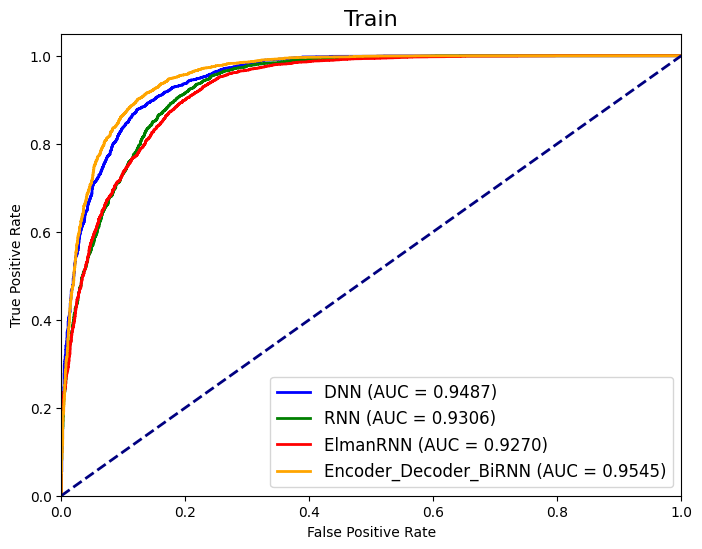

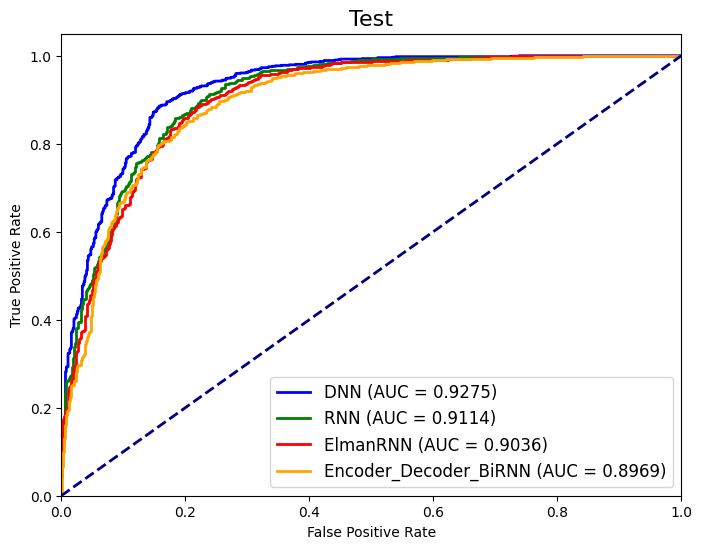

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, Input, Bidirectional, LSTM, RepeatVector, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Function to create models
def create_model(model_type, params, input_feature_count):
    if model_type == 'DNN':
        model = Sequential()
        model.add(Dense(units=params['units1'], activation='relu', input_dim=input_feature_count))
        model.add(Dropout(params['dropout1']))
        model.add(Dense(units=params['units2'], activation='relu'))
        model.add(Dropout(params['dropout2']))
        model.add(Dense(units=params['units3'], activation='relu'))
        model.add(Dropout(params['dropout3']))
        model.add(Dense(units=params['units4'], activation='relu'))
        model.add(Dropout(params['dropout4']))
        model.add(Dense(units=params['units5'], activation='relu'))
        model.add(Dropout(params['dropout5']))
        model.add(Dense(units=1, activation='sigmoid'))

    elif model_type == 'RNN':
        model = Sequential()
        model.add(SimpleRNN(units=params['units1'], activation='relu', input_shape=(input_feature_count, 1), return_sequences=True))
        model.add(Dropout(params['dropout1']))
        model.add(SimpleRNN(units=params['units2'], activation='relu', return_sequences=True))
        model.add(Dropout(params['dropout2']))
        model.add(SimpleRNN(units=params['units3'], activation='relu', return_sequences=True))
        model.add(Dropout(params['dropout3']))
        model.add(SimpleRNN(units=params['units4'], activation='relu'))
        model.add(Dropout(params['dropout4']))
        model.add(Dense(units=params['units5'], activation='relu'))
        model.add(Dropout(params['dropout5']))
        model.add(Dense(units=1, activation='sigmoid'))

    elif model_type == 'ElmanRNN':
        model = Sequential()
        model.add(SimpleRNN(units=params['units1'], activation='relu', input_shape=(input_feature_count, 1), return_sequences=False))
        model.add(Dropout(params['dropout1']))
        model.add(Dense(units=params['units2'], activation='relu'))
        model.add(Dropout(params['dropout2']))
        model.add(Dense(units=params['units3'], activation='relu'))
        model.add(Dropout(params['dropout3']))
        model.add(Dense(units=params['units4'], activation='relu'))
        model.add(Dropout(params['dropout4']))
        model.add(Dense(units=params['units5'], activation='relu'))
        model.add(Dropout(params['dropout5']))
        model.add(Dense(units=1, activation='sigmoid'))

    elif model_type == 'Encoder_Decoder_BiRNN':
        # Encoder
        encoder_inputs = Input(shape=(input_feature_count, 1))
        encoder = Bidirectional(LSTM(units=params['units1'], return_state=True, dropout=params['dropout1']))
        encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
        state_h = Concatenate()([forward_h, backward_h])
        state_c = Concatenate()([forward_c, backward_c])
        encoder_states = [state_h, state_c]

        # Decoder
        decoder_inputs = RepeatVector(1)(state_h)
        decoder_lstm = LSTM(units=params['units1'] * 2, return_sequences=False, dropout=params['dropout2'])
        decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
        decoder_dense = Dense(1, activation='sigmoid')
        outputs = decoder_dense(decoder_outputs)

        model = Model(inputs=encoder_inputs, outputs=outputs)

    return model

# Function to initialize GWO population
def initialize_gwo_population(pop_size, param_bounds):
    population = []
    for _ in range(pop_size):
        wolf = {
            'units1': np.random.randint(param_bounds['units1'][0], param_bounds['units1'][1] + 1),
            'units2': np.random.randint(param_bounds['units2'][0], param_bounds['units2'][1] + 1),
            'units3': np.random.randint(param_bounds['units3'][0], param_bounds['units3'][1] + 1),
            'units4': np.random.randint(param_bounds['units4'][0], param_bounds['units4'][1] + 1),
            'units5': np.random.randint(param_bounds['units5'][0], param_bounds['units5'][1] + 1),
            'dropout1': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1]),
            'dropout2': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1]),
            'dropout3': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1]),
            'dropout4': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1]),
            'dropout5': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1]),
            'fitness': None  # Initialize fitness
        }
        population.append(wolf)
    return population

# Optimize model using GWO
def gwo_optimize(model_type, X_train, y_train, X_val, y_val, input_feature_count):
    param_bounds = {
        'units1': (8, 128),
        'units2': (8, 64),
        'units3': (8, 32),
        'units4': (8, 16),
        'units5': (8, 8),
        'dropout': (0.1, 0.5)
    }
    population = initialize_gwo_population(5, param_bounds)  # Population size of 5 for GWO
    max_generations = 3

    best_fitness = float('inf')
    best_params = None

    # Initialize alpha, beta, and delta wolves
    alpha, beta, delta = None, None, None

    for generation in range(max_generations):
        a = 2 - generation * (2 / max_generations)  # Linearly decreased from 2 to 0

        # Evaluate all wolves
        for wolf in population:
            model = create_model(model_type, wolf, input_feature_count)
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            model.fit(X_train, y_train, epochs=20, verbose=0)  # Reduced verbosity for optimization
            loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
            wolf['fitness'] = loss  # Lower loss is better

            if alpha is None or wolf['fitness'] < alpha['fitness']:
                delta = beta
                beta = alpha
                alpha = wolf
            elif beta is None or wolf['fitness'] < beta['fitness']:
                delta = beta
                beta = wolf
            elif delta is None or wolf['fitness'] < delta['fitness']:
                delta = wolf

        # Update positions of wolves
        for wolf in population:
            for key in wolf.keys():
                if key == 'fitness':
                    continue
                r1, r2 = np.random.rand(), np.random.rand()

                A1 = 2 * a * r1 - a
                C1 = 2 * r2
                D_alpha = abs(C1 * alpha[key] - wolf[key])
                X1 = alpha[key] - A1 * D_alpha

                r1, r2 = np.random.rand(), np.random.rand()
                A2 = 2 * a * r1 - a
                C2 = 2 * r2
                D_beta = abs(C2 * beta[key] - wolf[key])
                X2 = beta[key] - A2 * D_beta

                r1, r2 = np.random.rand(), np.random.rand()
                A3 = 2 * a * r1 - a
                C3 = 2 * r2
                D_delta = abs(C3 * delta[key] - wolf[key])
                X3 = delta[key] - A3 * D_delta

                wolf[key] = (X1 + X2 + X3) / 3

                # Ensure the units are integers and valid
                if key.startswith('units'):
                    wolf[key] = max(8, int(round(wolf[key])))

                # Ensure dropouts remain within [0, 1] range
                if key.startswith('dropout'):
                    wolf[key] = min(max(wolf[key], 0), 1)

        # Track the best parameters found
        if alpha['fitness'] < best_fitness:
            best_fitness = alpha['fitness']
            best_params = alpha

        print(f"Generation {generation+1}/{max_generations}, Best Fitness: {best_fitness}")

    return best_params

# Example model optimization and evaluation
input_feature_count = X_train_selected.shape[1]

# Define model types including the new Encoder-Decoder BiRNN
model_types = ['DNN', 'RNN', 'ElmanRNN', 'Encoder_Decoder_BiRNN']
color_dict = {'DNN': 'blue', 'RNN': 'green', 'ElmanRNN': 'red', 'Encoder_Decoder_BiRNN': 'orange'}

# Initialize dictionary to store FPR, TPR, and AUC for each model
roc_data_train = {}
roc_data_test = {}
metrics_data = {}

# Optimize and evaluate each model
for model_type in model_types:
    best_params = gwo_optimize(model_type, X_train_selected, y_train, X_val_selected, y_val, input_feature_count)
    model = create_model(model_type, best_params, input_feature_count)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    X_train_reshaped = np.expand_dims(X_train_selected, axis=-1) if 'RNN' in model_type else X_train_selected
    X_val_reshaped = np.expand_dims(X_val_selected, axis=-1) if 'RNN' in model_type else X_val_selected
    X_test_reshaped = np.expand_dims(X_test_selected, axis=-1) if 'RNN' in model_type else X_test_selected

    model.fit(X_train_reshaped, y_train, epochs=30, batch_size=32, validation_data=(X_val_reshaped, y_val))

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")

    # Predict probabilities for the training set
    y_train_probs = model.predict(X_train_reshaped).ravel()

    # Predict probabilities for the test set
    y_test_probs = model.predict(X_test_reshaped).ravel()

    # Compute ROC curve and ROC area for the training set
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
    roc_auc_train = auc(fpr_train, tpr_train)

    # Compute ROC curve and ROC area for the test set
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)
    roc_auc_test = auc(fpr_test, tpr_test)

    roc_data_train[model_type] = {'fpr': fpr_train, 'tpr': tpr_train, 'auc': roc_auc_train}
    roc_data_test[model_type] = {'fpr': fpr_test, 'tpr': tpr_test, 'auc': roc_auc_test}

    # Calculate metrics
    y_test_pred = (y_test_probs >= 0.5).astype(int)  # Convert probabilities to binary predictions
    cm = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)  # Sensitivity
    specificity = tn / (tn + fp)
    f1 = f1_score(y_test, y_test_pred)

    metrics_data[model_type] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Sensitivity': recall,
        'Specificity': specificity,
        'F1 Score': f1
    }

# Convert the metrics dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics_data).transpose()

# Display the DataFrame
print(metrics_df)

# Optionally, save the DataFrame to a CSV file
metrics_df.to_csv('gwo_optimised_dnn_rnn_elman_metrics2.csv', index=True)

# Plot ROC curves for training data
plt.figure(figsize=(8, 6))
for model_type in roc_data_train.keys():
    plt.plot(roc_data_train[model_type]['fpr'], roc_data_train[model_type]['tpr'],
             color=color_dict[model_type], lw=2,
             label=f'{model_type} (AUC = {roc_data_train[model_type]["auc"]:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()

# Plot ROC curves for testing data
plt.figure(figsize=(8, 6))
for model_type in roc_data_test.keys():
    plt.plot(roc_data_test[model_type]['fpr'], roc_data_test[model_type]['tpr'],
             color=color_dict[model_type], lw=2,
             label=f'{model_type} (AUC = {roc_data_test[model_type]["auc"]:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()


In [ ]:
# Delete the codes before cell

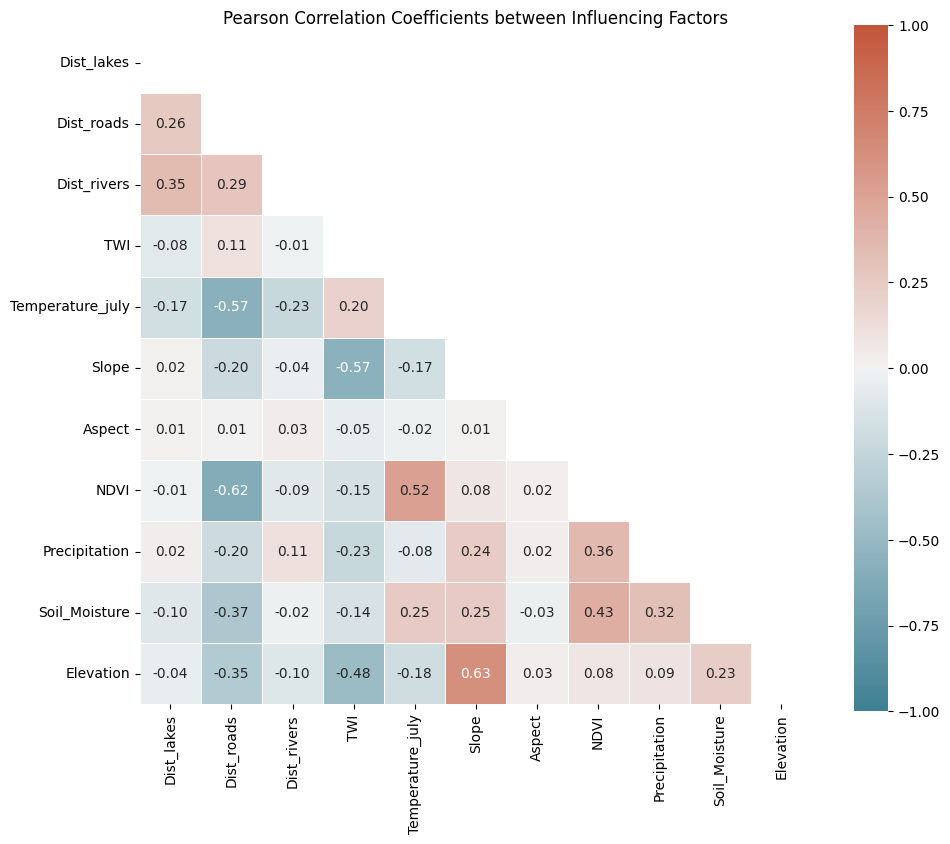

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

In [7]:
# Install required packages
!pip install shap boruta

# Import libraries
import pandas as pd
import numpy as np
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from boruta import BorutaPy
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, Bidirectional, LSTM, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

# Load the data
df = pd.read_csv('WF2_numeric.csv', names=[
    'Index', 'Wildfire_status', 'X', 'Y', 'Dist_lakes', 'Dist_roads', 'Dist_rivers', 'TWI',
    'Temperature_july', 'Slope', 'Aspect', 'LULC', 'NDVI', 'Precipitation', 'Soil_Moisture', 'Elevation'], header=0)

# Data Cleaning and Preprocessing
df = df[df['LULC'] != 0]
replace_values_LULC = {
    1: 'Urban_areas', 2: 'Crop_land', 3: 'Grass_land', 4: 'Tree_covered', 5: 'Shrub_covered',
    6: 'Herbaceous', 7: 'Sparse_vegetation', 8: 'Bare_soil', 9: 'Snow', 10: 'Water_bodies', 11: 'Sparse_vegetation'}
df['LULC'] = df['LULC'].replace(replace_values_LULC)
df = df.astype({'LULC': 'category'})

# Drop unnecessary columns
df = df.drop(columns=['Index', 'X', 'Y'], axis=1)

# Plot Pearson Correlation Coefficient heatmap
numerical_df = df.drop(columns=['LULC', 'Wildfire_status'])
correlation_matrix = numerical_df.corr(method='pearson')
plt.figure(figsize=(10, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, square=True, annot=True, fmt=".2f", linewidths=0.5, cbar_kws={"shrink": 0.75})
plt.title('Pearson Correlation Coefficients between Influencing Factors')
plt.tight_layout()
plt.show()

# Split the data into training, validation, and test sets
X = df.drop(columns=['Wildfire_status'])
y = df['Wildfire_status']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Data Preprocessing: Encode categorical and scale numerical features
categorical_columns = ['LULC']
numerical_columns = ['Dist_lakes', 'Dist_roads', 'Dist_rivers', 'TWI', 'Temperature_july', 'Slope', 'Aspect', 'NDVI', 'Precipitation', 'Soil_Moisture', 'Elevation']

encoder = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()

X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train[categorical_columns]), columns=encoder.get_feature_names_out(categorical_columns))
X_val_encoded = pd.DataFrame(encoder.transform(X_val[categorical_columns]), columns=encoder.get_feature_names_out(categorical_columns))
X_test_encoded = pd.DataFrame(encoder.transform(X_test[categorical_columns]), columns=encoder.get_feature_names_out(categorical_columns))

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[numerical_columns]), columns=numerical_columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val[numerical_columns]), columns=numerical_columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[numerical_columns]), columns=numerical_columns)

# Concatenate the encoded and scaled features
X_train_final = pd.concat([X_train_scaled.reset_index(drop=True), X_train_encoded.reset_index(drop=True)], axis=1)
X_val_final = pd.concat([X_val_scaled.reset_index(drop=True), X_val_encoded.reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_scaled.reset_index(drop=True), X_test_encoded.reset_index(drop=True)], axis=1)

# Feature Importance using Boruta and CART
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5, random_state=42)
rf.fit(X_train_final, y_train)

# Boruta Feature Selection
boruta = BorutaPy(estimator=rf, n_estimators='auto', max_iter=100, random_state=42)
boruta.fit(X_train_final.values, y_train.values)

# Feature Importance DataFrames
boruta_feature_stats = pd.DataFrame({'Variables': X_train_final.columns, 'BorutaDecision': ['Confirmed' if decision else 'Rejected' for decision in boruta.support_]})
cart_model = DecisionTreeClassifier(random_state=42)
cart_model.fit(X_train_final, y_train)
cart_feature_stats = pd.DataFrame({'Variables': X_train_final.columns, 'RelativeImportance': cart_model.feature_importances_})

# Combine Boruta and CART results
combined_feature_stats = boruta_feature_stats.merge(cart_feature_stats, on='Variables')
removed_features = pd.concat([combined_feature_stats[combined_feature_stats['BorutaDecision'] == 'Rejected']['Variables'], combined_feature_stats[combined_feature_stats['RelativeImportance'] < 0.001]['Variables']]).unique()

# Final feature set after Boruta and CART
X_train_selected = X_train_final.drop(columns=removed_features)
X_val_selected = X_val_final.drop(columns=removed_features)
X_test_selected = X_test_final.drop(columns=removed_features)

# Function to build and train deep learning models
def build_and_train_model(model_type, X_train, y_train, X_val, y_val, X_test, y_test):
    if model_type == 'DNN':
        model = Sequential()
        model.add(Dense(32, activation='relu', input_dim=X_train.shape[1]))
        model.add(Dropout(0.5))
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(8, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))

    elif model_type == 'RNN':
        model = Sequential()
        model.add(SimpleRNN(32, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True))
        model.add(Dropout(0.5))
        model.add(SimpleRNN(16, activation='relu', return_sequences=True))
        model.add(Dropout(0.5))
        model.add(SimpleRNN(8, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))

    elif model_type == 'ElmanRNN':
        model = Sequential()
        model.add(SimpleRNN(32, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=False))
        model.add(Dropout(0.5))
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(8, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))

    elif model_type == 'Encoder_Decoder_BiRNN':
        units = 128
        encoder_inputs = Input(shape=(X_train.shape[1], 1))
        encoder = Bidirectional(LSTM(units, return_state=True, dropout=0.5))
        encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
        state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
        state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])
        encoder_states = [state_h, state_c]

        decoder_inputs = tf.keras.layers.RepeatVector(1)(state_h)
        decoder_lstm = LSTM(units * 2, return_sequences=False, dropout=0.5)
        decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
        decoder_dense = Dense(1, activation='sigmoid')
        outputs = decoder_dense(decoder_outputs)

        model = Model(inputs=encoder_inputs, outputs=outputs)

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    if model_type != 'DNN':
        X_train = np.expand_dims(X_train, axis=-1)
        X_val = np.expand_dims(X_val, axis=-1)
        X_test = np.expand_dims(X_test, axis=-1)

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, verbose=0)

    y_train_proba = model.predict(X_train).ravel()
    y_test_proba = model.predict(X_test).ravel()
    train_auc = roc_auc_score(y_train, y_train_proba)
    test_auc = roc_auc_score(y_test, y_test_proba)

    y_train_pred = (y_train_proba > 0.5).astype(int)
    y_test_pred = (y_test_proba > 0.5).astype(int)

    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)

    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    specificity = cm_test[0, 0] / (cm_test[0, 0] + cm_test[0, 1])
    f1 = f1_score(y_test, y_test_pred)

    metrics = {'Accuracy': accuracy, 'Precision': precision, 'Sensitivity': recall, 'Specificity': specificity, 'F1 Score': f1}
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

    return fpr_train, tpr_train, train_auc, fpr_test, tpr_test, test_auc, cm_train, cm_test, metrics

# Prepare lists to store the results
fprs_train, tprs_train, aucs_train = [], [], []
fprs_test, tprs_test, aucs_test = [], [], []
cms_train, cms_test = [], []
metrics_data = {}

# Train models and gather ROC data and metrics
models = ['DNN', 'RNN', 'ElmanRNN', 'Encoder_Decoder_BiRNN']
for model_type in models:
    fpr_train, tpr_train, train_auc, fpr_test, tpr_test, test_auc, cm_train, cm_test, metrics = build_and_train_model(
        model_type, X_train_selected, y_train, X_val_selected, y_val, X_test_selected, y_test)

    fprs_train.append((fpr_train, tpr_train, train_auc))
    fprs_test.append((fpr_test, tpr_test, test_auc))
    cms_train.append(cm_train)
    cms_test.append(cm_test)
    metrics_data[model_type] = metrics

# Convert the metrics dictionary to a DataFrame and save to CSV
metrics_df = pd.DataFrame(metrics_data).transpose()
metrics_df.to_csv('model_metrics.csv', index=True)
print(metrics_df)

# Plot ROC curves for training and testing data
plt.figure(figsize=(8, 6))
for i, (fpr, tpr, auc) in enumerate(fprs_train):
    plt.plot(fpr, tpr, lw=2, label=f'{models[i]} (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(8, 6))
for i, (fpr, tpr, auc) in enumerate(fprs_test):
    plt.plot(fpr, tpr, lw=2, label=f'{models[i]} (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test')
plt.legend(loc="lower right")
plt.show()

# Display confusion matrices for training and testing data
for i, model_type in enumerate(models):
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cms_train[i])
    disp_train.plot()
    plt.title(f"Confusion Matrix - {model_type} - Training Data")
    plt.show()

    disp_test = ConfusionMatrixDisplay(confusion_matrix=cms_test[i])
    disp_test.plot()
    plt.title(f"Confusion Matrix - {model_type} - Testing Data")
    plt.show()


## Load DEM (subarea 1)Data and Preprocessing

In [23]:
df = pd.read_csv('WF2_Export1.csv')
df.head()

,OBJECTID,Dist_river,TWI2,temp_july2,slope2,aspect2,LULC2,NDVI2,pcp2,soilmois2,DEM_masked,numeric_Di,numeric__1
0,741594,230.150,8.77799,18.4,7.02738,297.150,4,0.469301,2055.13,27.7675,141,-9999.0,-9999.0
1,741595,228.223,8.39747,18.4,10.22340,251.408,4,0.469301,2055.13,27.7675,821,-9999.0,-9999.0
2,741596,226.318,7.96542,18.7,15.52600,143.323,4,0.469301,2037.15,28.0453,520,-9999.0,-9999.0
3,741597,-9999.000,-9999.00000,-9999.0,-9999.00000,-9999.000,-9999,-9999.000000,-9999.00,-9999.0000,123,-9999.0,-9999.0
4,741598,216.788,10.18070,17.7,11.98060,359.325,4,0.513649,2021.64,29.8466,201,-9999.0,-9999.0


In [24]:
# Load the DEM data subarea 1
df = pd.read_csv(
    'WF2_Export1.csv',
    names= [
        'ObjectID',
        'Dist_rivers',
        'TWI',
        'Temperature_july',
        'Slope',
        'Aspect',
        'LULC',
        'NDVI',
        'Precipitation',
        'Soil_Moisture',
        'Elevation',
        'Dist_lakes',
        'Dist_roads'
    ],
    header= 0
)

In [25]:
df.head()

,ObjectID,Dist_rivers,TWI,Temperature_july,Slope,Aspect,LULC,NDVI,Precipitation,Soil_Moisture,Elevation,Dist_lakes,Dist_roads
0,741594,230.150,8.77799,18.4,7.02738,297.150,4,0.469301,2055.13,27.7675,141,-9999.0,-9999.0
1,741595,228.223,8.39747,18.4,10.22340,251.408,4,0.469301,2055.13,27.7675,821,-9999.0,-9999.0
2,741596,226.318,7.96542,18.7,15.52600,143.323,4,0.469301,2037.15,28.0453,520,-9999.0,-9999.0
3,741597,-9999.000,-9999.00000,-9999.0,-9999.00000,-9999.000,-9999,-9999.000000,-9999.00,-9999.0000,123,-9999.0,-9999.0
4,741598,216.788,10.18070,17.7,11.98060,359.325,4,0.513649,2021.64,29.8466,201,-9999.0,-9999.0


In [26]:
new_order = [
             'ObjectID', 'Dist_lakes', 'Dist_roads', 'Dist_rivers', 'TWI', 'Temperature_july', 'Slope', 'Aspect', 'LULC', 'NDVI', 'Precipitation',
             'Soil_Moisture', 'Elevation'
            ]
df = df[new_order]

In [27]:
# Step 1: Replace -9999 with np.nan in the 'LULC' column
df['LULC'].replace(-9999, np.nan, inplace=True)

# Step 2: Replace np.nan with the number 3 in the 'LULC' column
df['LULC'].fillna(3, inplace=True)

In [28]:
replace_values_LULC = {
    1: 'Urban_areas',
    2: 'Crop_land',
    3: 'Grass_land',
    4: 'Tree_covered',
    5: 'Shrub_covered',
    6: 'Herbaceous',
    7: 'Sparse_vegetation',
    8: 'Bare_soil',
    9: 'Snow',
    10: 'Water_bodies',
    11: 'Sparse_vegetation'
}

df['LULC'] = df['LULC'].replace(replace_values_LULC)

In [29]:
# Convert necessary columns to categorical
df = df.astype(
    {
        'LULC': 'category'
    }
)
col_to_drop = ['ObjectID']
df = df.drop(columns= col_to_drop, axis= 1)

In [30]:
df

,Dist_lakes,Dist_roads,Dist_rivers,TWI,Temperature_july,Slope,Aspect,LULC,NDVI,Precipitation,Soil_Moisture,Elevation
0,-9999.000,-9999.000,230.150,8.77799,18.4,7.02738,297.150,Tree_covered,0.469301,2055.130,27.7675,141
1,-9999.000,-9999.000,228.223,8.39747,18.4,10.22340,251.408,Tree_covered,0.469301,2055.130,27.7675,821
2,-9999.000,-9999.000,226.318,7.96542,18.7,15.52600,143.323,Tree_covered,0.469301,2037.150,28.0453,520
3,-9999.000,-9999.000,-9999.000,-9999.00000,-9999.0,-9999.00000,-9999.000,Grass_land,-9999.000000,-9999.000,-9999.0000,123
4,-9999.000,-9999.000,216.788,10.18070,17.7,11.98060,359.325,Tree_covered,0.513649,2021.640,29.8466,201
...,...,...,...,...,...,...,...,...,...,...,...,...
999994,499.267,576.052,-9999.000,-9999.00000,-9999.0,-9999.00000,-9999.000,Grass_land,-9999.000000,-9999.000,-9999.0000,1
999995,497.905,577.130,76.596,13.59240,15.6,0.00000,-1.000,Grass_land,0.087070,201.154,16.2408,1
999996,-9999.000,-9999.000,117.358,-9999.00000,13.8,-9999.00000,-9999.000,Sparse_vegetation,-9999.000000,-9999.000,-9999.0000,26
999997,-9999.000,-9999.000,-9999.000,-9999.00000,-9999.0,-9999.00000,-9999.000,Grass_land,-9999.000000,-9999.000,-9999.0000,25


In [31]:
# Replace -9999 with np.nan
df.replace(-9999, np.nan, inplace=True)

# Fill missing values for distance-related columns with the mean
distance_columns = ['Dist_lakes', 'Dist_rivers', 'Dist_roads', 'Soil_Moisture',
                    'NDVI', 'Precipitation', 'Temperature_july']
for column in distance_columns:
    df[column].fillna(df[column].mean(), inplace=True)

# Fill missing values for slope, aspect, etc., with the median
environmental_columns = ['Slope', 'Aspect', 'TWI']
for column in environmental_columns:
    df[column].fillna(df[column].median(), inplace=True)

# Check if any missing values remain
print(df.isnull().sum())


Dist_lakes          0
Dist_roads          0
Dist_rivers         0
TWI                 0
Temperature_july    0
Slope               0
Aspect              0
LULC                0
NDVI                0
Precipitation       0
Soil_Moisture       0
Elevation           0
dtype: int64


In [32]:
df

,Dist_lakes,Dist_roads,Dist_rivers,TWI,Temperature_july,Slope,Aspect,LULC,NDVI,Precipitation,Soil_Moisture,Elevation
0,158.724397,451.926427,230.150000,8.77799,18.400000,7.027380,297.150,Tree_covered,0.469301,2055.130000,27.767500,141
1,158.724397,451.926427,228.223000,8.39747,18.400000,10.223400,251.408,Tree_covered,0.469301,2055.130000,27.767500,821
2,158.724397,451.926427,226.318000,7.96542,18.700000,15.526000,143.323,Tree_covered,0.469301,2037.150000,28.045300,520
3,158.724397,451.926427,80.434696,12.06415,19.797969,0.596645,161.565,Grass_land,0.225475,441.004357,28.936761,123
4,158.724397,451.926427,216.788000,10.18070,17.700000,11.980600,359.325,Tree_covered,0.513649,2021.640000,29.846600,201
...,...,...,...,...,...,...,...,...,...,...,...,...
999994,499.267000,576.052000,80.434696,12.06415,19.797969,0.596645,161.565,Grass_land,0.225475,441.004357,28.936761,1
999995,497.905000,577.130000,76.596000,13.59240,15.600000,0.000000,-1.000,Grass_land,0.087070,201.154000,16.240800,1
999996,158.724397,451.926427,117.358000,12.06415,13.800000,0.596645,161.565,Sparse_vegetation,0.225475,441.004357,28.936761,26
999997,158.724397,451.926427,80.434696,12.06415,19.797969,0.596645,161.565,Grass_land,0.225475,441.004357,28.936761,25


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Load the DEM data for subarea 1
df_unseen1 = pd.read_csv(
    'WF2_Export1.csv',
    names=[
        'ObjectID', 'Dist_rivers', 'TWI', 'Temperature_july', 'Slope', 'Aspect',
        'LULC', 'NDVI', 'Precipitation', 'Soil_Moisture', 'Elevation', 'Dist_lakes', 'Dist_roads'
    ],
    header=0
)

# Reordering columns for better readability
df_unseen1 = df_unseen1[['ObjectID', 'Dist_lakes', 'Dist_roads', 'Dist_rivers', 'TWI',
         'Temperature_july', 'Slope', 'Aspect', 'LULC', 'NDVI',
         'Precipitation', 'Soil_Moisture', 'Elevation']]

# Step 1: Replace -9999 with np.nan for missing value handling
df_unseen1.replace(-9999, np.nan, inplace=True)

# Step 2: Handle 'LULC' column - replace NaNs with 3 (for Grass_land) and map land-use categories
df_unseen1['LULC'].fillna(3, inplace=True)
land_use_mapping = {
    1: 'Urban_areas', 2: 'Crop_land', 3: 'Grass_land', 4: 'Tree_covered', 5: 'Shrub_covered',
    6: 'Herbaceous', 7: 'Sparse_vegetation', 8: 'Bare_soil', 9: 'Snow', 10: 'Water_bodies', 11: 'Sparse_vegetation'
}
df_unseen1['LULC'] = df_unseen1['LULC'].replace(land_use_mapping)

# Convert 'LULC' to categorical type
df_unseen1['LULC'] = df_unseen1['LULC'].astype('category')

# Drop 'ObjectID' column as it's not needed for modeling
df_unseen1.drop(columns=['ObjectID'], inplace=True)

# Step 3: Fill missing values
# Fill distance-related columns (Dist_lakes, Dist_rivers, Dist_roads) with their mean
distance_columns = ['Dist_lakes', 'Dist_rivers', 'Dist_roads', 'Soil_Moisture', 'NDVI', 'Precipitation', 'Temperature_july']
df_unseen1[distance_columns] = df_unseen1[distance_columns].fillna(df_unseen1[distance_columns].mean())

# Fill environmental features (Slope, Aspect, TWI) with their median
environmental_columns = ['Slope', 'Aspect', 'TWI']
df_unseen1[environmental_columns] = df_unseen1[environmental_columns].fillna(df_unseen1[environmental_columns].median())

# Step 4: Check if any missing values remain
missing_values = df_unseen1.isnull().sum()
print("Missing values per column:\n", missing_values)

# Display the first few rows of the cleaned dataset
print(df_unseen1.head())


Missing values per column:
 Dist_lakes          0
Dist_roads          0
Dist_rivers         0
TWI                 0
Temperature_july    0
Slope               0
Aspect              0
LULC                0
NDVI                0
Precipitation       0
Soil_Moisture       0
Elevation           0
dtype: int64
   Dist_lakes  Dist_roads  Dist_rivers       TWI  Temperature_july      Slope  \
0  158.724397  451.926427   230.150000   8.77799         18.400000   7.027380   
1  158.724397  451.926427   228.223000   8.39747         18.400000  10.223400   
2  158.724397  451.926427   226.318000   7.96542         18.700000  15.526000   
3  158.724397  451.926427    80.434696  12.06415         19.797969   0.596645   
4  158.724397  451.926427   216.788000  10.18070         17.700000  11.980600   

    Aspect          LULC      NDVI  Precipitation  Soil_Moisture  Elevation  
0  297.150  Tree_covered  0.469301    2055.130000      27.767500        141  
1  251.408  Tree_covered  0.469301    2055.130000   

In [34]:
df

,Dist_lakes,Dist_roads,Dist_rivers,TWI,Temperature_july,Slope,Aspect,LULC,NDVI,Precipitation,Soil_Moisture,Elevation
0,158.724397,451.926427,230.150000,8.77799,18.400000,7.027380,297.150,Tree_covered,0.469301,2055.130000,27.767500,141
1,158.724397,451.926427,228.223000,8.39747,18.400000,10.223400,251.408,Tree_covered,0.469301,2055.130000,27.767500,821
2,158.724397,451.926427,226.318000,7.96542,18.700000,15.526000,143.323,Tree_covered,0.469301,2037.150000,28.045300,520
3,158.724397,451.926427,80.434696,12.06415,19.797969,0.596645,161.565,Grass_land,0.225475,441.004357,28.936761,123
4,158.724397,451.926427,216.788000,10.18070,17.700000,11.980600,359.325,Tree_covered,0.513649,2021.640000,29.846600,201
...,...,...,...,...,...,...,...,...,...,...,...,...
999994,499.267000,576.052000,80.434696,12.06415,19.797969,0.596645,161.565,Grass_land,0.225475,441.004357,28.936761,1
999995,497.905000,577.130000,76.596000,13.59240,15.600000,0.000000,-1.000,Grass_land,0.087070,201.154000,16.240800,1
999996,158.724397,451.926427,117.358000,12.06415,13.800000,0.596645,161.565,Sparse_vegetation,0.225475,441.004357,28.936761,26
999997,158.724397,451.926427,80.434696,12.06415,19.797969,0.596645,161.565,Grass_land,0.225475,441.004357,28.936761,25


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999999 entries, 0 to 999998
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Dist_lakes        999999 non-null  float64 
 1   Dist_roads        999999 non-null  float64 
 2   Dist_rivers       999999 non-null  float64 
 3   TWI               999999 non-null  float64 
 4   Temperature_july  999999 non-null  float64 
 5   Slope             999999 non-null  float64 
 6   Aspect            999999 non-null  float64 
 7   LULC              999999 non-null  category
 8   NDVI              999999 non-null  float64 
 9   Precipitation     999999 non-null  float64 
 10  Soil_Moisture     999999 non-null  float64 
 11  Elevation         999999 non-null  int64   
dtypes: category(1), float64(10), int64(1)
memory usage: 84.9 MB


# Preprocessing unseen data from sub area 1

In [36]:
# Load the DEM data for subarea 1
df_unseen1 = pd.read_csv(
    'WF2_Export1.csv',
    names=[
        'ObjectID', 'Dist_rivers', 'TWI', 'Temperature_july', 'Slope', 'Aspect',
        'LULC', 'NDVI', 'Precipitation', 'Soil_Moisture', 'Elevation', 'Dist_lakes', 'Dist_roads'
    ],
    header=0
)

# Reordering columns for better readability
df_unseen1 = df_unseen1[['ObjectID', 'Dist_lakes', 'Dist_roads', 'Dist_rivers', 'TWI',
                         'Temperature_july', 'Slope', 'Aspect', 'LULC', 'NDVI',
                         'Precipitation', 'Soil_Moisture', 'Elevation']]

# Step 1: Replace -9999 with np.nan for missing value handling
df_unseen1.replace(-9999, np.nan, inplace=True)

# Step 2: Handle 'LULC' column - replace NaNs with 3 (for Grass_land) and map land-use categories
df_unseen1['LULC'].fillna(3, inplace=True)
land_use_mapping = {
    1: 'Urban_areas', 2: 'Crop_land', 3: 'Grass_land', 4: 'Tree_covered', 5: 'Shrub_covered',
    6: 'Herbaceous', 7: 'Sparse_vegetation', 8: 'Bare_soil', 9: 'Snow', 10: 'Water_bodies', 11: 'Sparse_vegetation'
}
df_unseen1['LULC'] = df_unseen1['LULC'].replace(land_use_mapping)

# Convert 'LULC' to categorical type
df_unseen1['LULC'] = df_unseen1['LULC'].astype('category')

# Drop 'ObjectID' column as it's not needed for modeling
df_unseen1.drop(columns=['ObjectID'], inplace=True)

# Step 3: Fill missing values
# Fill distance-related columns (Dist_lakes, Dist_rivers, Dist_roads) with their mean
distance_columns = ['Dist_lakes', 'Dist_rivers', 'Dist_roads', 'Soil_Moisture', 'NDVI', 'Precipitation', 'Temperature_july']
df_unseen1[distance_columns] = df_unseen1[distance_columns].fillna(df_unseen1[distance_columns].mean())

# Fill environmental features (Slope, Aspect, TWI) with their median
environmental_columns = ['Slope', 'Aspect', 'TWI']
df_unseen1[environmental_columns] = df_unseen1[environmental_columns].fillna(df_unseen1[environmental_columns].median())

# Step 4: Apply the pre-fitted OneHotEncoder and StandardScaler

# Step 4.1: Apply the encoder on the 'LULC' column
LULC_encoded_unseen = pd.DataFrame(encoder.transform(df_unseen1[['LULC']]), columns=encoder.get_feature_names_out(['LULC']))

# Step 4.2: Apply the scaler on the numerical columns
numerical_columns = ['Dist_lakes', 'Dist_roads', 'Dist_rivers', 'TWI', 'Temperature_july', 'Slope', 'Aspect', 'NDVI', 'Precipitation', 'Soil_Moisture', 'Elevation']
numerical_scaled_unseen = pd.DataFrame(scaler.transform(df_unseen1[numerical_columns]), columns=numerical_columns)

# Step 4.3: Concatenate the encoded categorical features and scaled numerical features
df_unseen1_preprocessed = pd.concat([numerical_scaled_unseen.reset_index(drop=True), LULC_encoded_unseen.reset_index(drop=True)], axis=1)

# Step 5: Drop features removed by Boruta and CART
# Use the list of removed features from your optimized deep learning models
# Assuming 'removed_features' contains the names of features that were dropped
df_unseen1_preprocessed = df_unseen1_preprocessed.drop(columns=removed_features)

# Step 6: Check the processed data
print("Processed unseen data for subarea 1 after removing selected features:")
print(df_unseen1_preprocessed.head())


Processed unseen data for subarea 1 after removing selected features:
   Dist_lakes  Dist_roads  Dist_rivers       TWI  Temperature_july     Slope  \
0    0.237491    0.735163     2.544629 -1.571744         -1.145246  1.347725   
1    0.237491    0.735163     2.514656 -1.744516         -1.145246  2.193479   
2    0.237491    0.735163     2.485025 -1.940684         -1.029679  3.596691   
3    0.237491    0.735163     0.215903 -0.079691         -0.606718 -0.354022   
4    0.237491    0.735163     2.336792 -0.934855         -1.414900  2.658482   

     Aspect      NDVI  Precipitation  Soil_Moisture  Elevation  \
0  1.122841  1.200131       4.737178      -0.192821  -0.942225   
1  0.694797  1.200131       4.737178      -0.192821   0.766128   
2 -0.316640  1.200131       4.678712      -0.175963   0.009931   
3 -0.145935 -0.753997      -0.511459      -0.121864  -0.987446   
4  1.704661  1.555556       4.628279      -0.066649  -0.791488   

   LULC_Bare_soil  LULC_Crop_land  LULC_Tree_covered

# Predict the Probability for the Export output 1 csv file using DNN model

In [37]:
df_unseen1_preprocessed

,Dist_lakes,Dist_roads,Dist_rivers,TWI,Temperature_july,Slope,Aspect,NDVI,Precipitation,Soil_Moisture,Elevation,LULC_Bare_soil,LULC_Crop_land,LULC_Tree_covered
0,0.237491,0.735163,2.544629,-1.571744,-1.145246,1.347725,1.122841,1.200131,4.737178,-0.192821,-0.942225,0.0,0.0,1.0
1,0.237491,0.735163,2.514656,-1.744516,-1.145246,2.193479,0.694797,1.200131,4.737178,-0.192821,0.766128,0.0,0.0,1.0
2,0.237491,0.735163,2.485025,-1.940684,-1.029679,3.596691,-0.316640,1.200131,4.678712,-0.175963,0.009931,0.0,0.0,1.0
3,0.237491,0.735163,0.215903,-0.079691,-0.606718,-0.354022,-0.145935,-0.753997,-0.511459,-0.121864,-0.987446,0.0,0.0,0.0
4,0.237491,0.735163,2.336792,-0.934855,-1.414900,2.658482,1.704661,1.555556,4.628279,-0.066649,-0.791488,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,3.393672,1.199422,0.215903,-0.079691,-0.606718,-0.354022,-0.145935,-0.753997,-0.511459,-0.121864,-1.293945,0.0,0.0,0.0
999995,3.381049,1.203454,0.156195,0.614198,-2.223865,-0.511911,-1.667184,-1.863238,-1.291378,-0.892330,-1.293945,0.0,0.0,0.0
999996,0.237491,0.735163,0.790222,-0.079691,-2.917263,-0.354022,-0.145935,-0.753997,-0.511459,-0.121864,-1.231138,0.0,0.0,0.0
999997,0.237491,0.735163,0.215903,-0.079691,-0.606718,-0.354022,-0.145935,-0.753997,-0.511459,-0.121864,-1.233650,0.0,0.0,0.0


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, Bidirectional, LSTM, Input, RepeatVector, Concatenate

# Define the model creation function
def create_model(model_type, params, input_feature_count):
    if model_type == 'ANN':
        model = Sequential()
        model.add(Dense(units=params['units1'], activation='relu', input_dim=input_feature_count))
        model.add(Dropout(params['dropout1']))
        model.add(Dense(units=params['units2'], activation='relu'))
        model.add(Dropout(params['dropout2']))
        model.add(Dense(units=params['units3'], activation='relu'))
        model.add(Dropout(params['dropout3']))
        model.add(Dense(units=params['units4'], activation='relu'))
        model.add(Dropout(params['dropout4']))
        model.add(Dense(units=params['units5'], activation='relu'))
        model.add(Dropout(params['dropout5']))
        model.add(Dense(units=1, activation='sigmoid'))

    elif model_type == 'RNN':
        model = Sequential()
        model.add(SimpleRNN(units=params['units1'], activation='relu', input_shape=(input_feature_count, 1), return_sequences=True))
        model.add(Dropout(params['dropout1']))
        model.add(SimpleRNN(units=params['units2'], activation='relu', return_sequences=True))
        model.add(Dropout(params['dropout2']))
        model.add(SimpleRNN(units=params['units3'], activation='relu'))
        model.add(Dropout(params['dropout3']))
        model.add(Dense(units=params['units4'], activation='relu'))
        model.add(Dropout(params['dropout4']))
        model.add(Dense(units=params['units5'], activation='relu'))
        model.add(Dropout(params['dropout5']))
        model.add(Dense(units=1, activation='sigmoid'))

    elif model_type == 'ElmanRNN':
        model = Sequential()
        model.add(SimpleRNN(units=params['units1'], activation='relu', input_shape=(input_feature_count, 1), return_sequences=False))
        model.add(Dropout(params['dropout1']))
        model.add(Dense(units=params['units2'], activation='relu'))
        model.add(Dropout(params['dropout2']))
        model.add(Dense(units=params['units3'], activation='relu'))
        model.add(Dropout(params['dropout3']))
        model.add(Dense(units=params['units4'], activation='relu'))
        model.add(Dropout(params['dropout4']))
        model.add(Dense(units=params['units5'], activation='relu'))
        model.add(Dropout(params['dropout5']))
        model.add(Dense(units=1, activation='sigmoid'))

    elif model_type == 'Encoder_Decoder_BiRNN':
        # Encoder
        encoder_inputs = Input(shape=(input_feature_count, 1))
        encoder = Bidirectional(LSTM(units=params['units1'], return_state=True, dropout=params['dropout1']))
        encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
        state_h = Concatenate()([forward_h, backward_h])
        state_c = Concatenate()([forward_c, backward_c])
        encoder_states = [state_h, state_c]

        # Decoder
        decoder_inputs = RepeatVector(1)(state_h)
        decoder_lstm = LSTM(units=params['units1'] * 2, return_sequences=False, dropout=params['dropout2'])
        decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
        decoder_dense = Dense(1, activation='sigmoid')
        outputs = decoder_dense(decoder_outputs)

        model = Model(inputs=encoder_inputs, outputs=outputs)

    return model

# Preprocessed data for unseen data (subarea 1)
input_feature_count = df_unseen1_preprocessed.shape[1]  # Number of input features

# Optimized parameters for each model (based on GWO results)
optimized_params_ann = {
    'units1': 64, 'units2': 32, 'units3': 16, 'units4': 8, 'units5': 8,
    'dropout1': 0.3, 'dropout2': 0.3, 'dropout3': 0.3, 'dropout4': 0.3, 'dropout5': 0.3
}

optimized_params_rnn = {
    'units1': 128, 'units2': 64, 'units3': 32, 'units4': 16, 'units5': 8,
    'dropout1': 0.4, 'dropout2': 0.4, 'dropout3': 0.4, 'dropout4': 0.4, 'dropout5': 0.4
}

optimized_params_elmanrnn = {
    'units1': 64, 'units2': 32, 'units3': 16, 'units4': 8, 'units5': 8,
    'dropout1': 0.3, 'dropout2': 0.3, 'dropout3': 0.3, 'dropout4': 0.3, 'dropout5': 0.3
}

optimized_params_encoder_decoder_birnn = {
    'units1': 128, 'dropout1': 0.3, 'dropout2': 0.3
}

# Create and compile models
ann_model = create_model('ANN', optimized_params_ann, input_feature_count)
rnn_model = create_model('RNN', optimized_params_rnn, input_feature_count)
elmanrnn_model = create_model('ElmanRNN', optimized_params_elmanrnn, input_feature_count)
encoder_decoder_birnn_model = create_model('Encoder_Decoder_BiRNN', optimized_params_encoder_decoder_birnn, input_feature_count)

# Compile models
for model in [ann_model, rnn_model, elmanrnn_model, encoder_decoder_birnn_model]:
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Predict wildfire probabilities for unseen data
wildfire_prob_ann = np.round(ann_model.predict(df_unseen1_preprocessed), 3)
wildfire_prob_rnn = np.round(rnn_model.predict(np.expand_dims(df_unseen1_preprocessed.values, axis=-1)), 3)
wildfire_prob_elmanrnn = np.round(elmanrnn_model.predict(np.expand_dims(df_unseen1_preprocessed.values, axis=-1)), 3)
wildfire_prob_birnn = np.round(encoder_decoder_birnn_model.predict(np.expand_dims(df_unseen1_preprocessed.values, axis=-1)), 3)

# Add FID column
df_unseen1_preprocessed['FID'] = range(0, len(df_unseen1_preprocessed))

# Create separate DataFrames for each model's predictions
df_predictions_ann = pd.DataFrame({
    'FID': df_unseen1_preprocessed['FID'],
    'Wildfire_probability': wildfire_prob_ann.ravel()
})

df_predictions_rnn = pd.DataFrame({
    'FID': df_unseen1_preprocessed['FID'],
    'Wildfire_probability': wildfire_prob_rnn.ravel()
})

df_predictions_elmanrnn = pd.DataFrame({
    'FID': df_unseen1_preprocessed['FID'],
    'Wildfire_probability': wildfire_prob_elmanrnn.ravel()
})

df_predictions_birnn = pd.DataFrame({
    'FID': df_unseen1_preprocessed['FID'],
    'Wildfire_probability': wildfire_prob_birnn.ravel()
})

# Save each to its respective CSV
df_predictions_ann.to_csv('wildfire_predictions_optimized_ann.csv', index=False)
df_predictions_rnn.to_csv('wildfire_predictions_optimized_rnn.csv', index=False)
df_predictions_elmanrnn.to_csv('wildfire_predictions_optimized_elmanrnn.csv', index=False)
df_predictions_birnn.to_csv('wildfire_predictions_optimized_birnn.csv', index=False)

print("Predictions saved as CSV files for all models.")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31250/31250 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 190s 6ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 96s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 544s 17ms/step
Predictions saved as CSV files for all models.


# Preprocessing unseen data from sub area 2

In [94]:
# Load the DEM data subarea 2
df_unseen2 = pd.read_csv(
    'WF2_Export2.csv',
    names= [
        'ObjectID',
        'Dist_lakes',
        'Dist_roads',
        'Dist_rivers',
        'TWI',
        'Temperature_july',
        'Slope',
        'Aspect',
        'LULC',
        'NDVI',
        'Precipitation',
        'Soil_Moisture',
        'Elevation'
    ],
    header= 0
)

# Reordering columns for better readability
df_unseen2 = df_unseen2[['ObjectID', 'Dist_lakes', 'Dist_roads', 'Dist_rivers', 'TWI',
                         'Temperature_july', 'Slope', 'Aspect', 'LULC', 'NDVI',
                         'Precipitation', 'Soil_Moisture', 'Elevation']]


In [95]:
df_unseen2

,ObjectID,Dist_lakes,Dist_roads,Dist_rivers,TWI,Temperature_july,Slope,Aspect,LULC,NDVI,Precipitation,Soil_Moisture,Elevation
0,1996415,6.16958,0.0,2.82843,12.8522,23.8,0.120110,206.565,4,0.509034,1081.90,88.2996,191.0
1,1996416,6.16958,0.0,4.24264,15.2662,23.8,0.204147,195.255,4,0.509034,1081.90,88.2996,198.0
2,1996417,6.16958,0.0,4.00000,13.8196,23.8,0.045649,168.690,4,0.509034,1091.79,87.9201,196.0
3,1996418,6.16958,0.0,4.70140,12.7872,23.9,0.256358,294.775,4,0.528172,1090.77,87.6774,204.0
4,1996419,6.16958,0.0,5.65685,12.4707,24.0,0.175887,345.256,4,0.535667,1098.03,87.1406,206.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017099,1244117,-9999.00000,-9999.0,244.62800,10.7203,18.5,1.012510,177.466,4,0.541732,1541.97,30.7271,97.0
1017100,1244118,-9999.00000,-9999.0,245.32600,10.2013,18.5,1.700990,122.101,6,0.541732,1541.97,30.7271,65.0
1017101,1244119,-9999.00000,-9999.0,-9999.00000,12.1816,18.9,1.408930,103.595,4,0.541732,1540.74,30.4312,57.0
1017102,1246371,-9999.00000,-9999.0,245.33600,11.4488,18.3,0.488698,298.443,4,0.534259,1518.08,30.8821,89.0


In [96]:
df_unseen2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017104 entries, 0 to 1017103
Data columns (total 13 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   ObjectID          1017104 non-null  int64  
 1   Dist_lakes        1017104 non-null  float64
 2   Dist_roads        1017104 non-null  float64
 3   Dist_rivers       1017104 non-null  float64
 4   TWI               1017104 non-null  float64
 5   Temperature_july  1017104 non-null  float64
 6   Slope             1017104 non-null  float64
 7   Aspect            1017104 non-null  float64
 8   LULC              1017104 non-null  int64  
 9   NDVI              1017104 non-null  float64
 10  Precipitation     1017104 non-null  float64
 11  Soil_Moisture     1017104 non-null  float64
 12  Elevation         1017104 non-null  float64
dtypes: float64(11), int64(2)
memory usage: 100.9 MB


In [97]:
df_unseen2[df_unseen2['LULC'] == -9999]

,ObjectID,Dist_lakes,Dist_roads,Dist_rivers,TWI,Temperature_july,Slope,Aspect,LULC,NDVI,Precipitation,Soil_Moisture,Elevation
21,1996608,6.16958,0.0000,2.82843,12.7692,-9999.0,0.261005,202.166,-9999,0.524663,1074.05,87.7521,185.0
41,1996799,6.16958,0.0000,-9999.00000,12.9111,-9999.0,0.113241,161.565,-9999,0.418789,1083.59,87.3321,189.0
94,1997362,-9999.00000,-9999.0000,0.00000,11.8410,-9999.0,0.330147,319.399,-9999,0.411973,1080.90,87.8165,196.0
95,1997363,0.00000,10.0730,2.00000,12.3218,-9999.0,0.204147,285.255,-9999,0.469051,1093.26,87.3263,208.0
124,1997730,0.00000,10.0730,0.00000,13.9759,-9999.0,0.273305,328.392,-9999,0.530519,1099.92,87.8340,184.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017044,1232762,-9999.00000,-9999.0000,231.74900,11.6598,-9999.0,1.187100,203.085,-9999,0.528538,1499.72,29.5645,42.0
1017053,1232771,0.00000,58.5077,263.05000,-9999.0000,-9999.0,-9999.000000,-9999.000,-9999,0.534792,1575.72,29.3628,58.0
1017071,1237299,-9999.00000,-9999.0000,236.09700,-9999.0000,-9999.0,-9999.000000,-9999.000,-9999,0.504995,1509.03,30.4434,45.0
1017080,1239572,-9999.00000,-9999.0000,-9999.00000,-9999.0000,-9999.0,-9999.000000,-9999.000,-9999,0.504995,1509.03,30.4434,30.0


In [98]:
# Step 1: Replace -9999 with np.nan for missing value handling
df_unseen2.replace(-9999, 3, inplace=True)

In [99]:
land_use_mapping = {
    1: 'Urban_areas', 2: 'Crop_land', 3: 'Grass_land', 4: 'Tree_covered', 5: 'Shrub_covered',
    6: 'Herbaceous', 7: 'Sparse_vegetation', 8: 'Bare_soil', 9: 'Snow', 10: 'Water_bodies', 11: 'Sparse_vegetation'
}
df_unseen2['LULC'] = df_unseen2['LULC'].replace(land_use_mapping)


In [100]:
# Convert 'LULC' to categorical type
df_unseen2['LULC'] = df_unseen2['LULC'].astype('category')
df_unseen2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017104 entries, 0 to 1017103
Data columns (total 13 columns):
 #   Column            Non-Null Count    Dtype   
---  ------            --------------    -----   
 0   ObjectID          1017104 non-null  int64   
 1   Dist_lakes        1017104 non-null  float64 
 2   Dist_roads        1017104 non-null  float64 
 3   Dist_rivers       1017104 non-null  float64 
 4   TWI               1017104 non-null  float64 
 5   Temperature_july  1017104 non-null  float64 
 6   Slope             1017104 non-null  float64 
 7   Aspect            1017104 non-null  float64 
 8   LULC              1017104 non-null  category
 9   NDVI              1017104 non-null  float64 
 10  Precipitation     1017104 non-null  float64 
 11  Soil_Moisture     1017104 non-null  float64 
 12  Elevation         1017104 non-null  float64 
dtypes: category(1), float64(11), int64(1)
memory usage: 94.1 MB


In [101]:
# Drop 'ObjectID' column as it's not needed for modeling
df_unseen2.drop(columns=['ObjectID'], inplace=True)


In [102]:
df_unseen2.tail()

,Dist_lakes,Dist_roads,Dist_rivers,TWI,Temperature_july,Slope,Aspect,LULC,NDVI,Precipitation,Soil_Moisture,Elevation
1017099,3.0,3.0,244.628,10.7203,18.5,1.012510,177.466,Tree_covered,0.541732,1541.97,30.7271,97.0
1017100,3.0,3.0,245.326,10.2013,18.5,1.700990,122.101,Herbaceous,0.541732,1541.97,30.7271,65.0
1017101,3.0,3.0,3.000,12.1816,18.9,1.408930,103.595,Tree_covered,0.541732,1540.74,30.4312,57.0
1017102,3.0,3.0,245.336,11.4488,18.3,0.488698,298.443,Tree_covered,0.534259,1518.08,30.8821,89.0
1017103,3.0,3.0,246.527,11.1832,18.4,1.274570,169.479,Sparse_vegetation,0.512625,1528.03,30.9724,27.0


In [103]:
df_unseen2[df_unseen2['TWI'] == -9999]

,Dist_lakes,Dist_roads,Dist_rivers,TWI,Temperature_july,Slope,Aspect,LULC,NDVI,Precipitation,Soil_Moisture,Elevation


In [104]:
# Step 3: Fill missing values
# Fill distance-related columns (Dist_lakes, Dist_rivers, Dist_roads) with their mean
distance_columns = ['Dist_lakes', 'Dist_rivers', 'Dist_roads', 'Soil_Moisture', 'NDVI', 'Precipitation', 'Temperature_july', 'Elevation']
df_unseen2[distance_columns] = df_unseen2[distance_columns].fillna(df_unseen2[distance_columns].mean())

# Fill environmental features (Slope, Aspect, TWI) with their median
environmental_columns = ['Slope', 'Aspect', 'TWI']
df_unseen2[environmental_columns] = df_unseen2[environmental_columns].fillna(df_unseen2[environmental_columns].median())

# Step 4: Apply the pre-fitted OneHotEncoder and StandardScaler

# Step 4.1: Apply the encoder on the 'LULC' column
LULC_encoded_unseen = pd.DataFrame(encoder.transform(df_unseen2[['LULC']]), columns=encoder.get_feature_names_out(['LULC']))

# Step 4.2: Apply the scaler on the numerical columns
numerical_columns = ['Dist_lakes', 'Dist_roads', 'Dist_rivers', 'TWI', 'Temperature_july', 'Slope', 'Aspect', 'NDVI', 'Precipitation', 'Soil_Moisture', 'Elevation']
numerical_scaled_unseen = pd.DataFrame(scaler.transform(df_unseen2[numerical_columns]), columns=numerical_columns)

# Step 4.3: Concatenate the encoded categorical features and scaled numerical features
df_unseen2_preprocessed = pd.concat([numerical_scaled_unseen.reset_index(drop=True), LULC_encoded_unseen.reset_index(drop=True)], axis=1)

# Step 5: Drop features removed by Boruta and CART
# Use the list of removed features from your optimized deep learning models
# Assuming 'removed_features' contains the names of features that were dropped
df_unseen2_preprocessed = df_unseen2_preprocessed.drop(columns=removed_features)


In [105]:
df_unseen2_preprocessed

,Dist_lakes,Dist_roads,Dist_rivers,TWI,Temperature_july,Slope,Aspect,NDVI,Precipitation,Soil_Moisture,Elevation,LULC_Bare_soil,LULC_Crop_land,LULC_Tree_covered
0,-1.176402,-0.955149,-0.991213,0.278117,0.934949,-0.480127,0.275165,1.518569,1.572535,3.480626,-0.816611,0.0,0.0,1.0
1,-1.176402,-0.955149,-0.969216,1.374173,0.934949,-0.457888,0.169329,1.518569,1.572535,3.480626,-0.799025,0.0,0.0,1.0
2,-1.176402,-0.955149,-0.972990,0.717357,0.934949,-0.499831,-0.079261,1.518569,1.604694,3.457596,-0.804050,0.0,0.0,1.0
3,-1.176402,-0.955149,-0.962080,0.248604,0.973471,-0.444072,1.100616,1.671950,1.601378,3.442867,-0.783951,0.0,0.0,1.0
4,-1.176402,-0.955149,-0.947219,0.104900,1.011993,-0.465366,1.573006,1.732018,1.624985,3.410291,-0.778927,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017099,-1.205778,-0.943928,2.769825,-0.689854,-1.106724,-0.243973,0.002863,1.780625,3.068540,-0.013215,-1.052766,0.0,0.0,1.0
1017100,-1.205778,-0.943928,2.780682,-0.925502,-1.106724,-0.061783,-0.515231,1.780625,3.068540,-0.013215,-1.133159,0.0,0.0,0.0
1017101,-1.205778,-0.943928,-0.988544,-0.026363,-0.952635,-0.139070,-0.688406,1.780625,3.064541,-0.031172,-1.153257,0.0,0.0,1.0
1017102,-1.205778,-0.943928,2.780838,-0.359085,-1.183768,-0.382588,1.134940,1.720734,2.990857,-0.003809,-1.072864,0.0,0.0,1.0


In [75]:
# Load the DEM data subarea 2
df_unseen2 = pd.read_csv(
    'WF2_Export2.csv',
    names= [
        'ObjectID',
        'Dist_lakes',
        'Dist_roads',
        'Dist_rivers',
        'TWI',
        'Temperature_july',
        'Slope',
        'Aspect',
        'LULC',
        'NDVI',
        'Precipitation',
        'Soil_Moisture',
        'Elevation'
    ],
    header= 0
)

# Reordering columns for better readability
df_unseen2 = df_unseen2[['ObjectID', 'Dist_lakes', 'Dist_roads', 'Dist_rivers', 'TWI',
                         'Temperature_july', 'Slope', 'Aspect', 'LULC', 'NDVI',
                         'Precipitation', 'Soil_Moisture', 'Elevation']]

# Step 1: Replace -9999 with np.nan for missing value handling
df_unseen2.replace(-9999, np.nan, inplace=True)

# Step 2: Handle 'LULC' column - replace NaNs with 3 (for Grass_land) and map land-use categories
df_unseen2['LULC'].fillna(3, inplace=True)
land_use_mapping = {
    1: 'Urban_areas', 2: 'Crop_land', 3: 'Grass_land', 4: 'Tree_covered', 5: 'Shrub_covered',
    6: 'Herbaceous', 7: 'Sparse_vegetation', 8: 'Bare_soil', 9: 'Snow', 10: 'Water_bodies', 11: 'Sparse_vegetation'
}
df_unseen2['LULC'] = df_unseen2['LULC'].replace(land_use_mapping)

# Convert 'LULC' to categorical type
df_unseen2['LULC'] = df_unseen2['LULC'].astype('category')

# Drop 'ObjectID' column as it's not needed for modeling
df_unseen2.drop(columns=['ObjectID'], inplace=True)

# Step 3: Fill missing values
# Fill distance-related columns (Dist_lakes, Dist_rivers, Dist_roads) with their mean
distance_columns = ['Dist_lakes', 'Dist_rivers', 'Dist_roads', 'Soil_Moisture', 'NDVI', 'Precipitation', 'Temperature_july', 'Elevation']
df_unseen2[distance_columns] = df_unseen2[distance_columns].fillna(df_unseen2[distance_columns].mean())

# Fill environmental features (Slope, Aspect, TWI) with their median
environmental_columns = ['Slope', 'Aspect', 'TWI']
df_unseen2[environmental_columns] = df_unseen2[environmental_columns].fillna(df_unseen2[environmental_columns].median())

# Step 4: Apply the pre-fitted OneHotEncoder and StandardScaler

# Step 4.1: Apply the encoder on the 'LULC' column
LULC_encoded_unseen = pd.DataFrame(encoder.transform(df_unseen2[['LULC']]), columns=encoder.get_feature_names_out(['LULC']))

# Step 4.2: Apply the scaler on the numerical columns
numerical_columns = ['Dist_lakes', 'Dist_roads', 'Dist_rivers', 'TWI', 'Temperature_july', 'Slope', 'Aspect', 'NDVI', 'Precipitation', 'Soil_Moisture', 'Elevation']
numerical_scaled_unseen = pd.DataFrame(scaler.transform(df_unseen2[numerical_columns]), columns=numerical_columns)

# Step 4.3: Concatenate the encoded categorical features and scaled numerical features
df_unseen2_preprocessed = pd.concat([numerical_scaled_unseen.reset_index(drop=True), LULC_encoded_unseen.reset_index(drop=True)], axis=1)

# Step 5: Drop features removed by Boruta and CART
# Use the list of removed features from your optimized deep learning models
# Assuming 'removed_features' contains the names of features that were dropped
df_unseen2_preprocessed = df_unseen2_preprocessed.drop(columns=removed_features)

# Step 6: Check the processed data
print("Processed unseen data for subarea 2 after removing selected features:")
print(df_unseen2_preprocessed.head())


Processed unseen data for subarea 2 after removing selected features:
   Dist_lakes  Dist_roads  Dist_rivers       TWI  Temperature_july     Slope  \
0   -1.176402   -0.955149    -0.991213  0.278117          0.934949 -0.480127   
1   -1.176402   -0.955149    -0.969216  1.374173          0.934949 -0.457888   
2   -1.176402   -0.955149    -0.972990  0.717357          0.934949 -0.499831   
3   -1.176402   -0.955149    -0.962080  0.248604          0.973471 -0.444072   
4   -1.176402   -0.955149    -0.947219  0.104900          1.011993 -0.465366   

     Aspect      NDVI  Precipitation  Soil_Moisture  Elevation  \
0  0.275165  1.518569       1.572535       3.480626  -0.816611   
1  0.169329  1.518569       1.572535       3.480626  -0.799025   
2 -0.079261  1.518569       1.604694       3.457596  -0.804050   
3  1.100616  1.671950       1.601378       3.442867  -0.783951   
4  1.573006  1.732018       1.624985       3.410291  -0.778927   

   LULC_Bare_soil  LULC_Crop_land  LULC_Tree_covered

# Predict the Probability for the Export output 2 csv file using DNN model

In [106]:
df_unseen2_preprocessed

,Dist_lakes,Dist_roads,Dist_rivers,TWI,Temperature_july,Slope,Aspect,NDVI,Precipitation,Soil_Moisture,Elevation,LULC_Bare_soil,LULC_Crop_land,LULC_Tree_covered
0,-1.176402,-0.955149,-0.991213,0.278117,0.934949,-0.480127,0.275165,1.518569,1.572535,3.480626,-0.816611,0.0,0.0,1.0
1,-1.176402,-0.955149,-0.969216,1.374173,0.934949,-0.457888,0.169329,1.518569,1.572535,3.480626,-0.799025,0.0,0.0,1.0
2,-1.176402,-0.955149,-0.972990,0.717357,0.934949,-0.499831,-0.079261,1.518569,1.604694,3.457596,-0.804050,0.0,0.0,1.0
3,-1.176402,-0.955149,-0.962080,0.248604,0.973471,-0.444072,1.100616,1.671950,1.601378,3.442867,-0.783951,0.0,0.0,1.0
4,-1.176402,-0.955149,-0.947219,0.104900,1.011993,-0.465366,1.573006,1.732018,1.624985,3.410291,-0.778927,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017099,-1.205778,-0.943928,2.769825,-0.689854,-1.106724,-0.243973,0.002863,1.780625,3.068540,-0.013215,-1.052766,0.0,0.0,1.0
1017100,-1.205778,-0.943928,2.780682,-0.925502,-1.106724,-0.061783,-0.515231,1.780625,3.068540,-0.013215,-1.133159,0.0,0.0,0.0
1017101,-1.205778,-0.943928,-0.988544,-0.026363,-0.952635,-0.139070,-0.688406,1.780625,3.064541,-0.031172,-1.153257,0.0,0.0,1.0
1017102,-1.205778,-0.943928,2.780838,-0.359085,-1.183768,-0.382588,1.134940,1.720734,2.990857,-0.003809,-1.072864,0.0,0.0,1.0


In [107]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, Bidirectional, LSTM, Input, RepeatVector, Concatenate

# Define the model creation function
def create_model(model_type, params, input_feature_count):
    if model_type == 'ANN':
        model = Sequential()
        model.add(Dense(units=params['units1'], activation='relu', input_dim=input_feature_count))
        model.add(Dropout(params['dropout1']))
        model.add(Dense(units=params['units2'], activation='relu'))
        model.add(Dropout(params['dropout2']))
        model.add(Dense(units=params['units3'], activation='relu'))
        model.add(Dropout(params['dropout3']))
        model.add(Dense(units=params['units4'], activation='relu'))
        model.add(Dropout(params['dropout4']))
        model.add(Dense(units=params['units5'], activation='relu'))
        model.add(Dropout(params['dropout5']))
        model.add(Dense(units=1, activation='sigmoid'))

    elif model_type == 'RNN':
        model = Sequential()
        model.add(SimpleRNN(units=params['units1'], activation='relu', input_shape=(input_feature_count, 1), return_sequences=True))
        model.add(Dropout(params['dropout1']))
        model.add(SimpleRNN(units=params['units2'], activation='relu', return_sequences=True))
        model.add(Dropout(params['dropout2']))
        model.add(SimpleRNN(units=params['units3'], activation='relu'))
        model.add(Dropout(params['dropout3']))
        model.add(Dense(units=params['units4'], activation='relu'))
        model.add(Dropout(params['dropout4']))
        model.add(Dense(units=params['units5'], activation='relu'))
        model.add(Dropout(params['dropout5']))
        model.add(Dense(units=1, activation='sigmoid'))

    elif model_type == 'ElmanRNN':
        model = Sequential()
        model.add(SimpleRNN(units=params['units1'], activation='relu', input_shape=(input_feature_count, 1), return_sequences=False))
        model.add(Dropout(params['dropout1']))
        model.add(Dense(units=params['units2'], activation='relu'))
        model.add(Dropout(params['dropout2']))
        model.add(Dense(units=params['units3'], activation='relu'))
        model.add(Dropout(params['dropout3']))
        model.add(Dense(units=params['units4'], activation='relu'))
        model.add(Dropout(params['dropout4']))
        model.add(Dense(units=params['units5'], activation='relu'))
        model.add(Dropout(params['dropout5']))
        model.add(Dense(units=1, activation='sigmoid'))

    elif model_type == 'Encoder_Decoder_BiRNN':
        # Encoder
        encoder_inputs = Input(shape=(input_feature_count, 1))
        encoder = Bidirectional(LSTM(units=params['units1'], return_state=True, dropout=params['dropout1']))
        encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
        state_h = Concatenate()([forward_h, backward_h])
        state_c = Concatenate()([forward_c, backward_c])
        encoder_states = [state_h, state_c]

        # Decoder
        decoder_inputs = RepeatVector(1)(state_h)
        decoder_lstm = LSTM(units=params['units1'] * 2, return_sequences=False, dropout=params['dropout2'])
        decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
        decoder_dense = Dense(1, activation='sigmoid')
        outputs = decoder_dense(decoder_outputs)

        model = Model(inputs=encoder_inputs, outputs=outputs)

    return model

# Preprocessed data for unseen data (subarea 2)
input_feature_count = df_unseen2_preprocessed.shape[1]  # Number of input features

# Optimized parameters for each model (based on GWO results)
optimized_params_ann = {
    'units1': 64, 'units2': 32, 'units3': 16, 'units4': 8, 'units5': 8,
    'dropout1': 0.3, 'dropout2': 0.3, 'dropout3': 0.3, 'dropout4': 0.3, 'dropout5': 0.3
}

optimized_params_rnn = {
    'units1': 128, 'units2': 64, 'units3': 32, 'units4': 16, 'units5': 8,
    'dropout1': 0.4, 'dropout2': 0.4, 'dropout3': 0.4, 'dropout4': 0.4, 'dropout5': 0.4
}

optimized_params_elmanrnn = {
    'units1': 64, 'units2': 32, 'units3': 16, 'units4': 8, 'units5': 8,
    'dropout1': 0.3, 'dropout2': 0.3, 'dropout3': 0.3, 'dropout4': 0.3, 'dropout5': 0.3
}

optimized_params_encoder_decoder_birnn = {
    'units1': 128, 'dropout1': 0.3, 'dropout2': 0.3
}

# Create and compile models
ann_model = create_model('ANN', optimized_params_ann, input_feature_count)
rnn_model = create_model('RNN', optimized_params_rnn, input_feature_count)
elmanrnn_model = create_model('ElmanRNN', optimized_params_elmanrnn, input_feature_count)
encoder_decoder_birnn_model = create_model('Encoder_Decoder_BiRNN', optimized_params_encoder_decoder_birnn, input_feature_count)

# Compile models
for model in [ann_model, rnn_model, elmanrnn_model, encoder_decoder_birnn_model]:
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Predict wildfire probabilities for unseen data
wildfire_prob_ann = np.round(ann_model.predict(df_unseen2_preprocessed), 3)
wildfire_prob_rnn = np.round(rnn_model.predict(np.expand_dims(df_unseen2_preprocessed.values, axis=-1)), 3)
wildfire_prob_elmanrnn = np.round(elmanrnn_model.predict(np.expand_dims(df_unseen2_preprocessed.values, axis=-1)), 3)
wildfire_prob_birnn = np.round(encoder_decoder_birnn_model.predict(np.expand_dims(df_unseen2_preprocessed.values, axis=-1)), 3)

# Add FID column
df_unseen2_preprocessed['FID'] = range(0, len(df_unseen2_preprocessed))

# Create separate DataFrames for each model's predictions
df_predictions_ann = pd.DataFrame({
    'FID': df_unseen2_preprocessed['FID'],
    'Wildfire_probability': wildfire_prob_ann.ravel()
})

df_predictions_rnn = pd.DataFrame({
    'FID': df_unseen2_preprocessed['FID'],
    'Wildfire_probability': wildfire_prob_rnn.ravel()
})

df_predictions_elmanrnn = pd.DataFrame({
    'FID': df_unseen2_preprocessed['FID'],
    'Wildfire_probability': wildfire_prob_elmanrnn.ravel()
})

df_predictions_birnn = pd.DataFrame({
    'FID': df_unseen2_preprocessed['FID'],
    'Wildfire_probability': wildfire_prob_birnn.ravel()
})

# Save each to its respective CSV
df_predictions_ann.to_csv('wildfire_predictions_optimized_ann2.csv', index=False)
df_predictions_rnn.to_csv('wildfire_predictions_optimized_rnn2.csv', index=False)
df_predictions_elmanrnn.to_csv('wildfire_predictions_optimized_elmanrnn2.csv', index=False)
df_predictions_birnn.to_csv('wildfire_predictions_optimized_birnn2.csv', index=False)

print("Predictions saved as CSV files for all models.")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31785/31785 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step
31785/31785 ━━━━━━━━━━━━━━━━━━━━ 191s 6ms/step
31785/31785 ━━━━━━━━━━━━━━━━━━━━ 90s 3ms/step
31785/31785 ━━━━━━━━━━━━━━━━━━━━ 579s 18ms/step
Predictions saved as CSV files for all models.
